<a href="https://colab.research.google.com/github/shwbak/HAI-Anomaly-Detection/blob/main/DAE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSH 키 발급

In [ ]:
!ssh-keygen

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:hxamGuRvNDGEmM5Ipu9MxvqpMNb5yKenBaaqTy8sCkw root@d1a63b335cd2
The key's randomart image is:
+---[RSA 3072]----+
|   o ..          |
| oo ..           |
|++  . o o        |
|o oo   = o       |
| E oo + S .      |
|o O o= o .       |
|+@.o..o          |
|Bo*o++           |
|B=+**.           |
+----[SHA256]-----+


In [ ]:
%cd ~/.ssh/

/root/.ssh


In [ ]:
! cat id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABgQDZRZQXql/SeFdLMr9663dSij6fGFH4NLIW8gJ5c4OWh+lpbWMky7cGU2YlAp02McR9MIAHci2dSMiYX1fORX/RsO3iNHhxw2aPjavk51dr+2qa7agm6zJDalfdJHBXJ0nNp+ugcoXXFI/000VxZU3O+5OvOLJcIZAXQmL9BEFexsNQyE5I4Cd5sGbS66Roy771Olub0QGQoHnzUL9mAc0ZgkP3isN3XHqlIewN4rn4fBox1ncHLf+I+NjE6K3RXqQ6iAmpEUlaQhcCoYJiSCZWsIsAR7JCad/lEt0Ctz+8JPj1hbd+IBOM3Tf2YHWQ2dVu6LEdXBa/LJ5ntiBf6K+QE3do8iBC56gaRFZDArL86xHSnH35qBNgVkCePP0Kj/uRr7tpASQA/nUlVNs14CyoSLd+cUgNfDUzxOUrSJjCy4w8TKhY+F/qUjAjlnRbBMwMM1/hvNiysId+OKWJxM/3ueF2XGuH9dqlSuscrmNiZ6feHV5iS7oxuiXcxKCQzMM= root@d1a63b335cd2


# Git 연동 확인

In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

/bin/bash: /root/.ssh/known_hosts: No such file or directory


In [ ]:
!ssh -T git@github.com

Host key verification failed.


#구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Github Origin을 Pull

In [ ]:
from os.path import join
from os import makedirs

PROJ_path = "/content/drive/MyDrive/Colab Notebooks/"
%cd "{PROJ_path}"
try:
  makedirs("HAI-Anomaly-Detection")
  REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
  %cd "{REPO_path}"
  !git init
  !git config --global user.email "minseok4864@ajou.ac.kr"
  !git config --global user.name "minseok4864"
  !git remote add origin https://github.com/shwbak/HAI-Anomaly-Detection

  !pip install --upgrade git-lfs

  !git lfs install
  !git lfs track "*.csv"
  !git add .gitattributes
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks
동일한 이름의 폴더가 이미 존재합니다.


Pull 코드

In [2]:
REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
%cd "{REPO_path}"

!pip install --upgrade git-lfs

!git init
!git config --global user.email "minseok4864@ajou.ac.kr"
!git config --global user.name "minseok4864"
!git pull origin main

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/.git/
From https://github.com/shwbak/HAI-Anomaly-Detection
 * branch            main       -> FETCH_HEAD
Already up to date.


#소스코드

In [3]:
%cd "{REPO_path}"
!pip install eTaPR-21.8.2-py3-none-any.whl

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./eTaPR-21.8.2-py3-none-any.whl


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', label="loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [26]:
import torch.nn as nn

device = get_default_device()


class Autoencoder(nn.Module):
    def __init__(self, in_size, latent_size, noise_std=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_size, int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), latent_size),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), in_size),
            nn.Sigmoid()
        )
        self.noise_std = noise_std

    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_std
        return x + noise
  
  
    def training_step(self, batch, epoch):
        noisy_batch = self.add_noise(batch)
        z = self.encoder(noisy_batch)
        out = self.decoder(z)
        loss1 = nn.MSELoss()(out, batch)
        loss2 = nn.L1Loss()(out, batch)
        return loss1, loss2

    def validation_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss = nn.MSELoss()(out, batch)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


def evaluate(model, val_loader, epoch):
    outputs = [model.validation_step(to_device(batch, device), epoch) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(list(model.encoder.parameters()) + list(model.decoder.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch = to_device(batch, device)
            loss1, loss2 = model.training_step(batch, epoch+1)
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader, epoch + 1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def testing(model, test_loader):
    results = []
    for [batch] in test_loader:
        batch = to_device(batch, device)
        z = model.encoder(batch)
        reconstructed = model.decoder(z)
        results.append(torch.mean((batch - reconstructed)**2, axis=1))
    return results

In [2]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from tqdm import tqdm

In [3]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [4]:
TRAIN_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/validation/").glob("*.csv")])

In [5]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_01 = dataframe_from_csv(TRAIN_DATASET[0])
TRAIN_DF_RAW_01.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_02 = dataframe_from_csv(TRAIN_DATASET[1])
TRAIN_DF_RAW_02.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_03 = dataframe_from_csv(TRAIN_DATASET[2])
TRAIN_DF_RAW_03.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_04 = dataframe_from_csv(TRAIN_DATASET[3])
TRAIN_DF_RAW_04.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_05 = dataframe_from_csv(TRAIN_DATASET[4])
TRAIN_DF_RAW_05.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_06 = dataframe_from_csv(TRAIN_DATASET[5])
TRAIN_DF_RAW_06.reset_index(drop=True,inplace=True)

print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


아래 두 목록에는 중복된 장치들이 있으니 이 점 유의하시면 좋을 것 같습니다.

변화가 없는 장치 목록
- C22, C52, C63, C82, C85, C55, C36, C26, C49, C38, C39, C29, C18, C19, C09

범주형 데이터 형태인 장치 목록
- C02, C07, C08, C09, C10, C17, C18, C19, C22, C26, C29, C34, C35, C36, C38, C39, C46, C48, C49, C52, C55, C58, C61, C63, C64, C69, C79, C82, C85

예측의 Loss 값이 튀는 경우를 없애주기 위해서 범주형 데이터의 경우 제외시켜주었습니다.

하지만 유의미한 결과를 보지는 못했던 것 같습니다.

In [6]:
TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["C02", "C07", "C08", "C09", "C10", "C17", "C18", "C19", "C22", "C26", "C29", "C34", "C35", "C36", "C38", "C39", "C46", "C48", "C49", "C52", "C55", "C58", "C61", "C63", "C64", "C69", "C79", "C82", "C85"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW_01.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET = VALID_COLUMNS_IN_TRAIN_DATASET.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C11', 'C12', 'C13', 'C14', 'C15',
       'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31',
       'C32', 'C33', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C47',
       'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C59', 'C60', 'C62', 'C65',
       'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76',
       'C77', 'C78', 'C80', 'C81', 'C83', 'C84', 'C86'],
      dtype='object')

In [7]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [8]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [9]:
TRAIN_DF_01 = normalize(TRAIN_DF_RAW_01[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_02 = normalize(TRAIN_DF_RAW_02[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_03 = normalize(TRAIN_DF_RAW_03[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_04 = normalize(TRAIN_DF_RAW_04[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_05 = normalize(TRAIN_DF_RAW_05[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_06 = normalize(TRAIN_DF_RAW_06[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [10]:
from skimage.restoration import denoise_wavelet

def dataframe_DN(df):
  temp = pd.DataFrame(df)

  for colnam in VALID_COLUMNS_IN_TRAIN_DATASET:
    temp[colnam] = denoise_wavelet(df[colnam], method='BayesShrink',  sigma=0.1)
    #temp[colnam] = denoise_wavelet(df[colnam], method='VisuShrink', wavelet_levels=3, sigma=0.1)    
  return temp

In [11]:
TRAIN_DF_01_DN = dataframe_DN(TRAIN_DF_01)
TRAIN_DF_02_DN = dataframe_DN(TRAIN_DF_02)
TRAIN_DF_03_DN = dataframe_DN(TRAIN_DF_03)
TRAIN_DF_04_DN = dataframe_DN(TRAIN_DF_04)
TRAIN_DF_05_DN = dataframe_DN(TRAIN_DF_05)
TRAIN_DF_06_DN = dataframe_DN(TRAIN_DF_06)

/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: overflow encountered in true_divide
  thresholded = (1 - value/magnitude)


In [12]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [13]:
window_size=12

windows_normal_01 = TRAIN_DF_01_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_01.shape[0]-window_size)[:, None]]
windows_normal_02 = TRAIN_DF_02_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_02.shape[0]-window_size)[:, None]]
windows_normal_03 = TRAIN_DF_03_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_03.shape[0]-window_size)[:, None]]
windows_normal_04 = TRAIN_DF_04_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_04.shape[0]-window_size)[:, None]]
windows_normal_05 = TRAIN_DF_05_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_05.shape[0]-window_size)[:, None]]
windows_normal_06 = TRAIN_DF_06_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_06.shape[0]-window_size)[:, None]]

In [14]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal_01.shape[1]*windows_normal_01.shape[2]
z_size=windows_normal_01.shape[1]*hidden_size

train_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_01).float().view(([windows_normal_01.shape[0],w_size])))
train_loader_02 = data_utils.TensorDataset(torch.from_numpy(windows_normal_02).float().view(([windows_normal_02.shape[0],w_size])))
train_loader_03 = data_utils.TensorDataset(torch.from_numpy(windows_normal_03).float().view(([windows_normal_03.shape[0],w_size])))
train_loader_04 = data_utils.TensorDataset(torch.from_numpy(windows_normal_04).float().view(([windows_normal_04.shape[0],w_size])))
train_loader_05 = data_utils.TensorDataset(torch.from_numpy(windows_normal_05).float().view(([windows_normal_05.shape[0],w_size])))

val_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_06).float().view(([windows_normal_06.shape[0],w_size])))

train_loader = torch.utils.data.DataLoader(data_utils.ConcatDataset(
    [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_loader_01, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [27]:
model = Autoencoder(w_size, z_size)
model = to_device(model,device)

In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=684, out_features=342, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=342, out_features=171, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=171, out_features=1200, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1200, out_features=171, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=171, out_features=342, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=342, out_features=684, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss: 0.0318
Epoch [1], val_loss: 0.0256
Epoch [2], val_loss: 0.0252
Epoch [3], val_loss: 0.0249
Epoch [4], val_loss: 0.0247
Epoch [5], val_loss: 0.0245
Epoch [6], val_loss: 0.0244
Epoch [7], val_loss: 0.0246
Epoch [8], val_loss: 0.0246
Epoch [9], val_loss: 0.0244
Epoch [10], val_loss: 0.0242
Epoch [11], val_loss: 0.0240
Epoch [12], val_loss: 0.0231
Epoch [13], val_loss: 0.0185
Epoch [14], val_loss: 0.0169
Epoch [15], val_loss: 0.0169
Epoch [16], val_loss: 0.0166
Epoch [17], val_loss: 0.0164
Epoch [18], val_loss: 0.0164
Epoch [19], val_loss: 0.0164
Epoch [20], val_loss: 0.0164
Epoch [21], val_loss: 0.0162
Epoch [22], val_loss: 0.0160
Epoch [23], val_loss: 0.0160
Epoch [24], val_loss: 0.0159
Epoch [25], val_loss: 0.0159
Epoch [26], val_loss: 0.0158
Epoch [27], val_loss: 0.0159
Epoch [28], val_loss: 0.0161
Epoch [29], val_loss: 0.0157
Epoch [30], val_loss: 0.0157
Epoch [31], val_loss: 0.0157
Epoch [32], val_loss: 0.0152
Epoch [33], val_loss: 0.0151
Epoch [34], val_loss: 0.

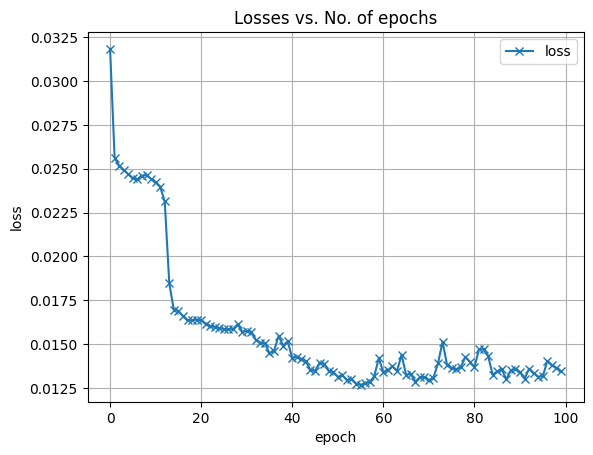

In [ ]:
plot_history(history)

In [ ]:
from os.path import join
from os import makedirs

%cd "{REPO_path}"
try:
  makedirs("models")
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
동일한 이름의 폴더가 이미 존재합니다.


In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict()
            }, "./models/usad.pth")

In [ ]:
checkpoint = torch.load("./models/usad.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

In [16]:
VALIDATION_DF_RAW = dataframe_from_csv(VALIDATION_DATASET[0])
VALIDATION_DF_RAW.reset_index(drop=True,inplace=True)

In [17]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

다양한 모델을 사용하였습니다만, Train Set을 기준으로 Min-Max Normalize를 진행한 뒤, Validation Set과 Test Set에 대해 Train Dataset의 Min값 혹은 Max값을 넘어가는 값에 x2, x1.5를 해주었을 경우 성능이 소폭 향상되는 모습을 보여주었습니다.

Min-Max Normalization이 어느정도 Anomaly Detection에서 효과를 보여준다는 걸 보여주는 것으로도 볼 수 있고, 값이 튀는 장치들에 실제로도 보안위협이 들어왔다고 생각할 수도 있을 것 같습니다.

In [18]:
for i in tqdm(range(VALIDATION_DF.shape[0])):
    for j in range(VALIDATION_DF.shape[1]):
        if VALIDATION_DF.iloc[i, j] < 0:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2
        elif VALIDATION_DF.iloc[i, j] > 1:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2

100%|██████████| 86400/86400 [03:00<00:00, 477.75it/s]


In [19]:
val = VALIDATION_DF.values[np.arange(window_size)[None, :] + np.arange(VALIDATION_DF.shape[0]-window_size)[:, None]]

In [20]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val).float().view(([val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results = testing(model,test_loader)

In [ ]:
labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]

In [ ]:
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [50]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * np.array(peak) * np.array(0.3))
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

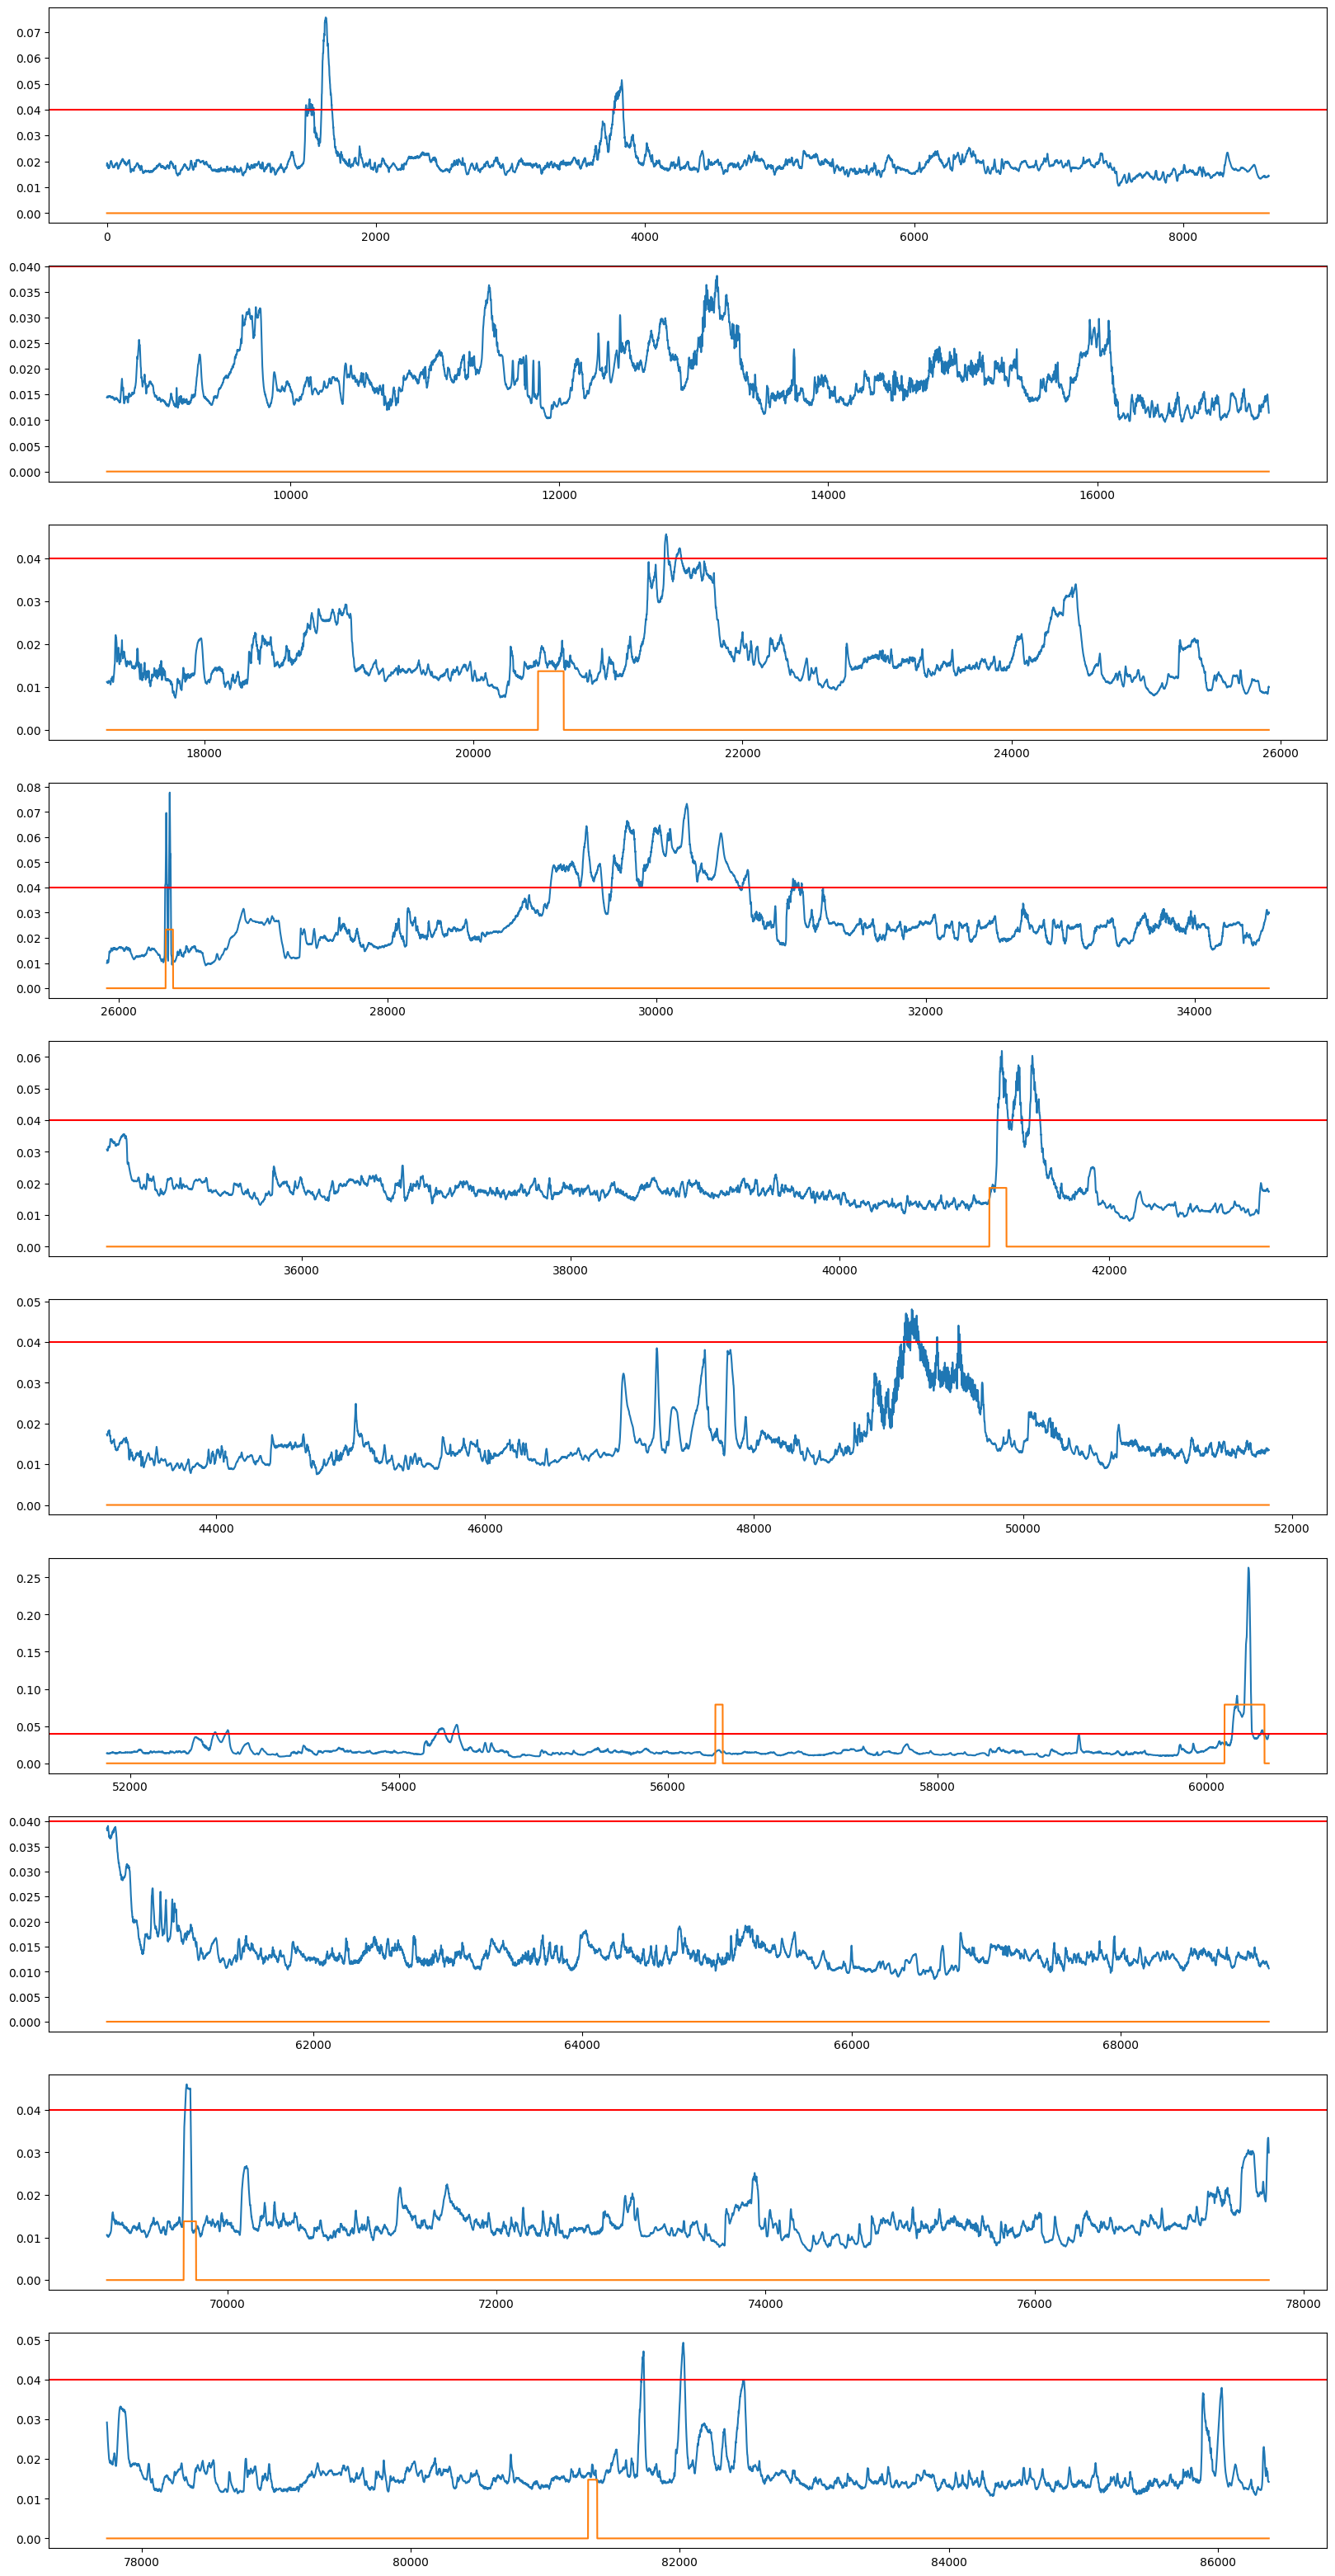

In [ ]:
THRESHOLD = 0.04
check_graph(y_pred, labels, piece=10, THRESHOLD=THRESHOLD)

In [53]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [ ]:
LABELS = put_labels(y_pred, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86388,))

In [ ]:
a = np.zeros(window_size)
LABELS = np.append(a, LABELS, axis=0)

In [ ]:
TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.140 (TaP: 0.087, TaR: 0.362)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fa2f0d4dcc0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fa2f0d4d6c0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fa2f0d4d8a0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fa2f0d4db10>]


# 양방향 LSTM

In [15]:
import torch.nn as nn

device = get_default_device()


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.sigmoid = nn.Sigmoid()
 

        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.ReLU(True),
            nn.Linear(int(input_size/2), int(input_size/4)),
            nn.ReLU(True),
            nn.Linear(int(input_size/4), hidden_size),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, int(input_size/4)),
            nn.ReLU(True),
            nn.Linear(int(input_size/4), int(input_size/2)),
            nn.ReLU(True),
            nn.Linear(int(input_size/2), input_size),
            nn.Sigmoid()
        )
  
    def training_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss1 = nn.MSELoss()(out, batch)
        loss2 = nn.L1Loss()(out, batch)
        return loss1, loss2

    def validation_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss = nn.MSELoss()(out, batch)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


def evaluate(model, val_loader, epoch):
    outputs = [model.validation_step(to_device(batch, device), epoch) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training_LSTM(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(list(model.encoder.parameters()) + list(model.decoder.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch = to_device(batch, device)
            loss1, loss2 = model.training_step(batch, epoch+1)
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader, epoch + 1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def testing(model, test_loader):
    results = []
    for [batch] in test_loader:
        batch = to_device(batch, device)
        z = model.encoder(batch)
        reconstructed = model.decoder(z)
        results.append(torch.mean((batch - reconstructed)**2, axis=1))
    return results

In [ ]:
model_LSTM = BiLSTM(w_size, z_size)
model_LSTM = to_device(model_LSTM,device)
history_LSTM = training_LSTM(N_EPOCHS,model_LSTM,train_loader,val_loader)

In [55]:
model_LSTM

BiLSTM(
  (lstm): LSTM(684, 1200, bidirectional=True)
  (fc): Linear(in_features=2400, out_features=1200, bias=True)
  (sigmoid): Sigmoid()
  (encoder): Sequential(
    (0): Linear(in_features=684, out_features=342, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=342, out_features=171, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=171, out_features=1200, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1200, out_features=171, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=171, out_features=342, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=342, out_features=684, bias=True)
    (5): Sigmoid()
  )
)

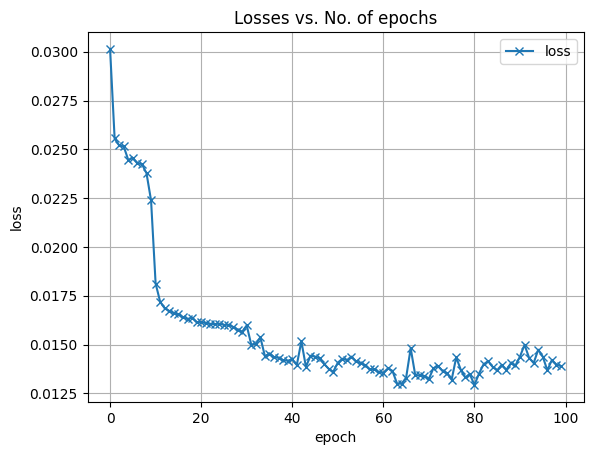

In [47]:
plot_history(history_LSTM)

In [48]:
results = testing(model_LSTM,test_loader)
labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

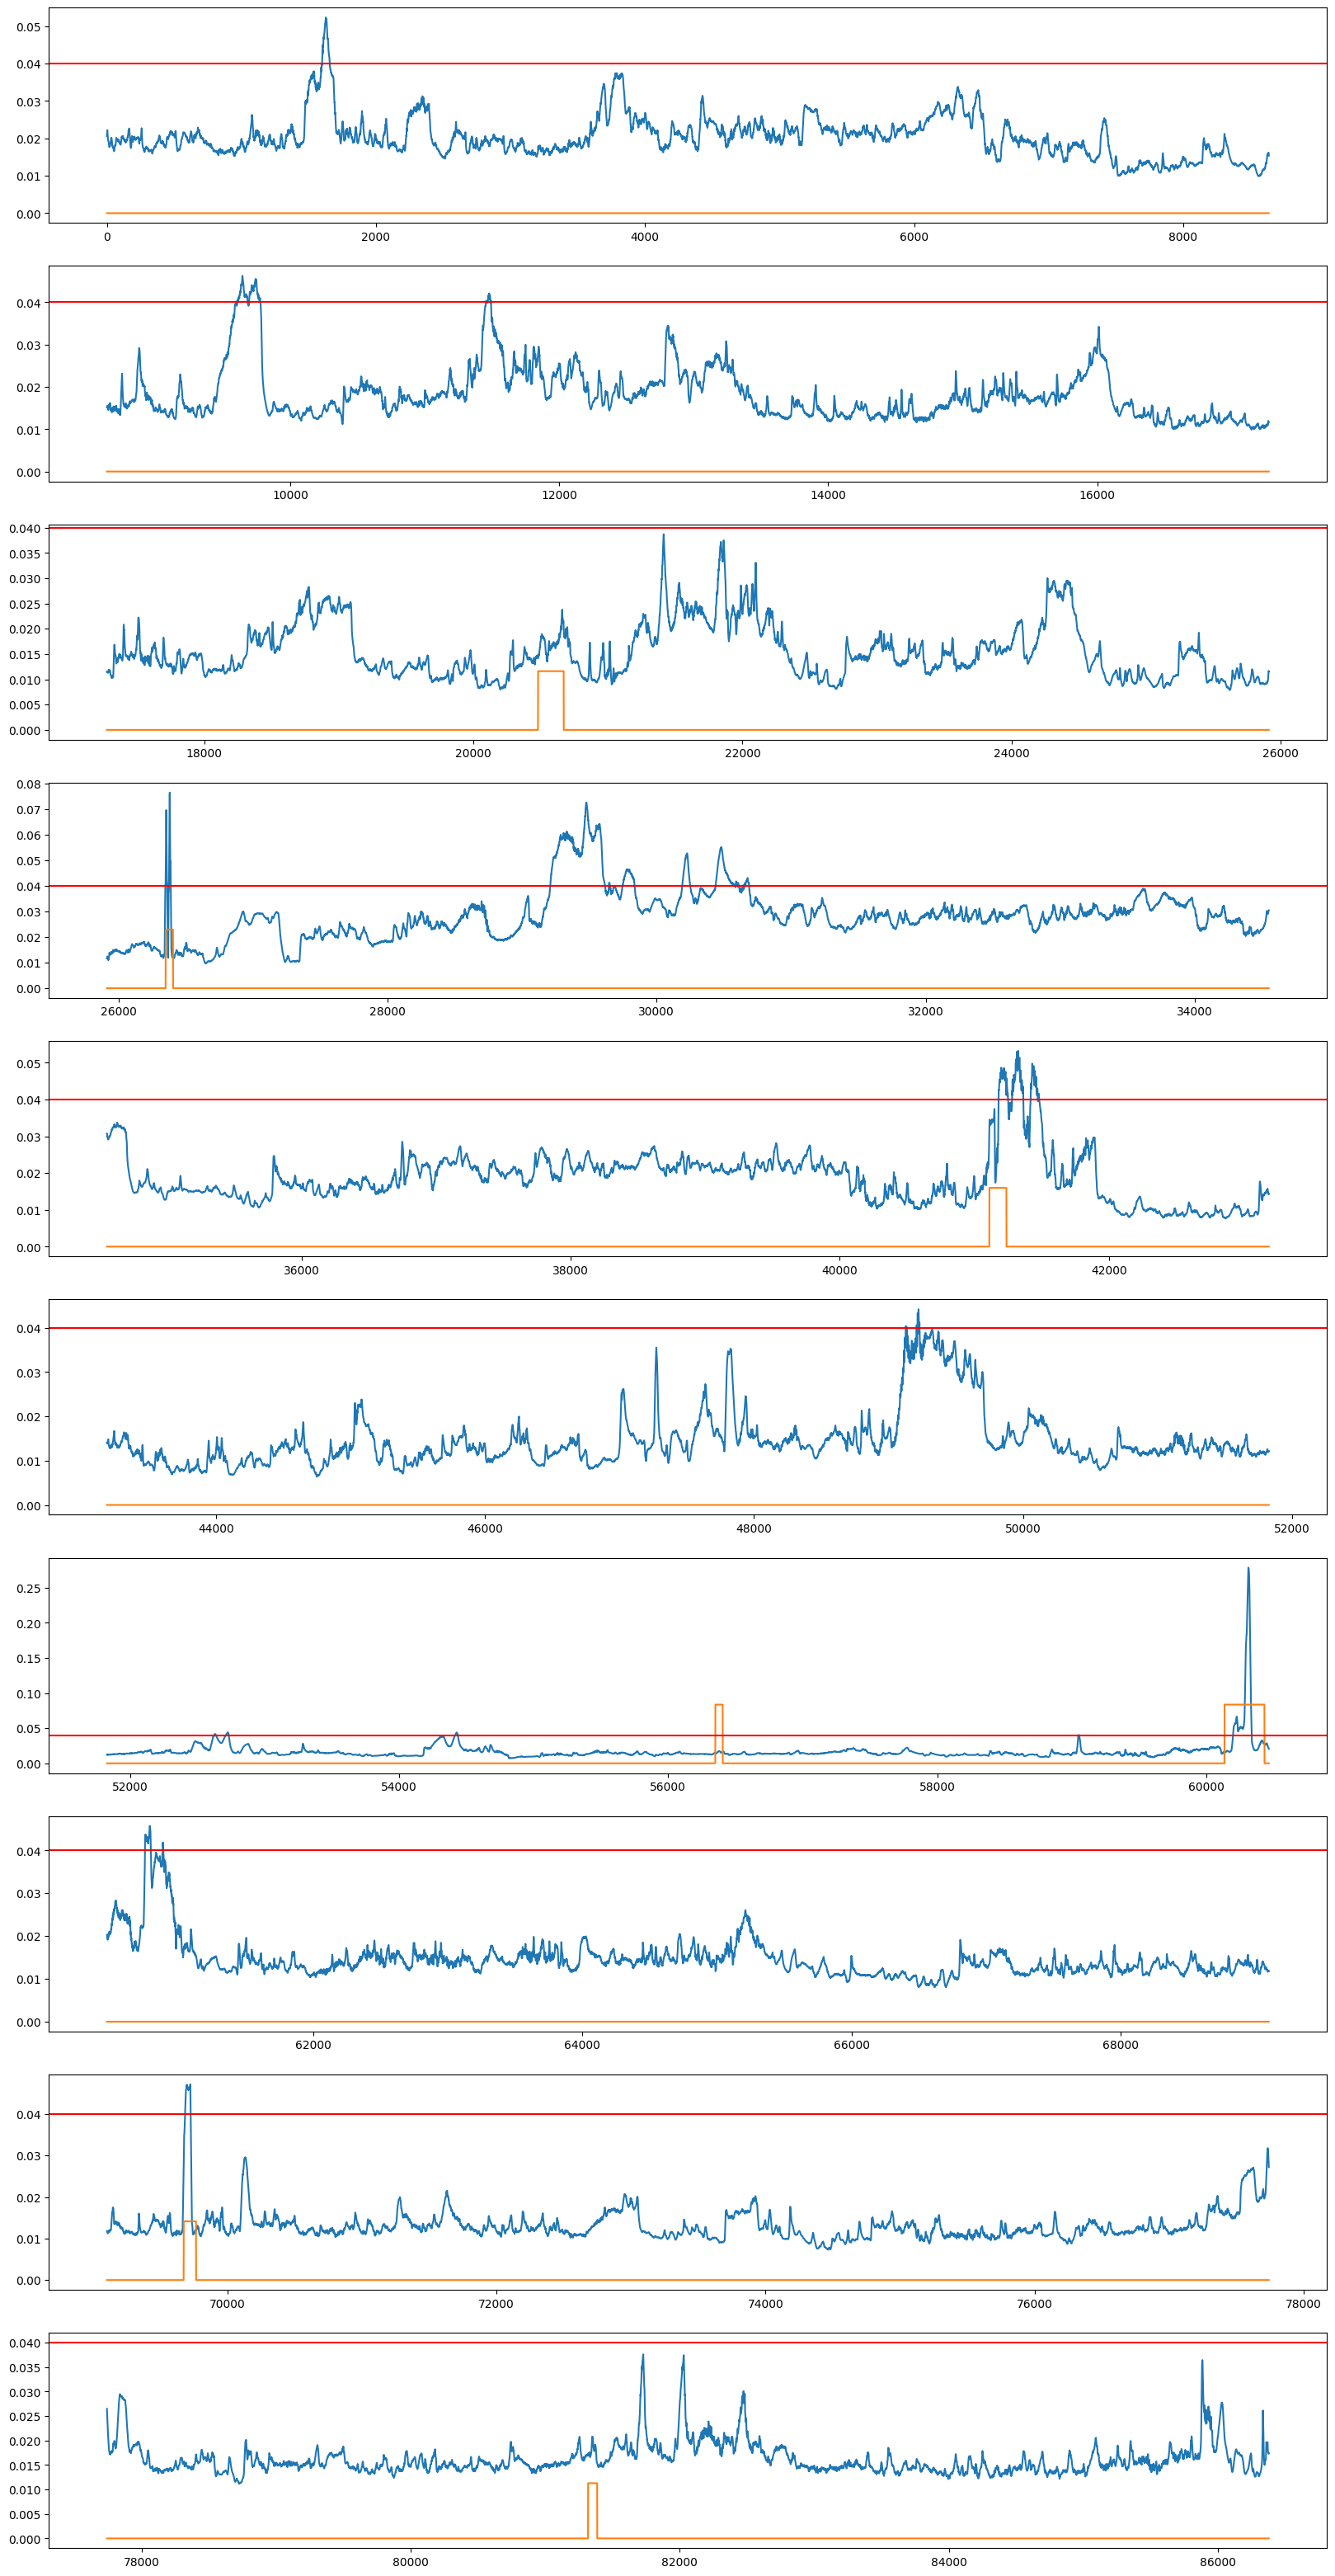

In [51]:
THRESHOLD = 0.04
check_graph(y_pred, labels, piece=10, THRESHOLD=THRESHOLD)

In [54]:
LABELS = put_labels(y_pred, THRESHOLD)
LABELS, LABELS.shape
a = np.zeros(window_size)
LABELS = np.append(a, LABELS, axis=0)

TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.150 (TaP: 0.096, TaR: 0.340)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fc18c5dd4b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fc18c5dd120>, <TaPR_pkg.DataManage.Range.Range object at 0x7fc18c5dd7b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fc18c5fc610>]
